In [1]:
from optimization_functions import *

# optimization parameters set in preprocess_functions.py

import pandas as pd

from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'

import pickle
import csv

In [2]:
# Parcel pickup (N^p) and delivery (N^d)
# [Parcel ID | time (minutes) | pickup_x (km) | pickup_y | delivery_x | delivery_y | immediate: False=0, True=1]

# Option 1: toy network for testing
# task_array = np.array([[0, 1, 1, 3.7, 3, 2.5,  0], 
#                        [1, 3, 1, 1, 5, 3.7, 0], 
#                        [2, 10, 2, 1, 5.2, 3.5, 0],
#                        [3, 14, 4.2, 1, 3.2, 0.5, 0],
#                        [4, 20, 5, 3, 5.5, 3.5, 0]])

# task_array = np.array([[0, 1, 1, 3.7, 3, 2.5,  0], 
#                        [1, 3, 1, 1, 5, 3.7, 0]])

# Option 2: a larger network
num_tasks = 49
with open('DATA_PDPD-SL/' + str(num_tasks) + 'tasks', 'rb') as f:
    task_array = pickle.load(f)

# take a subset of tasks to test
task_array = task_array[:10]



In [3]:
task_df = pd.DataFrame(columns=['ID', 'time', 'pickup_x', 'pickup_y', 'delivery_x', 'delivery_y', 'immediate'],
                       data=task_array)
num_tasks = len(task_df)

In [4]:
# # Option 2: a larger network
with open('DATA_PDPD-SL/1busline', 'rb') as f:
    stop_array = pickle.load(f)

# take a subset of bus stops to test
# stop_array = stop_array[:2]

stop_df = pd.DataFrame(columns=['ID', 'line', 'stop_x', 'stop_y'],
                       data=stop_array)

num_stops = len(stop_df)

In [5]:
stop_df

,ID,line,stop_x,stop_y
0,0.0,0.0,3.0,2.0
1,1.0,0.0,3.0,3.0
2,2.0,0.0,3.0,4.0
3,3.0,0.0,3.0,5.0
4,4.0,0.0,3.0,6.0
5,5.0,0.0,3.0,7.0
6,6.0,0.0,3.0,7.0
7,7.0,0.0,4.0,7.0
8,8.0,0.0,5.0,7.0
9,9.0,0.0,6.0,7.0


In [6]:
bus_travel_times = calc_bus_travel_times(num_stops, stop_df, v_bus)

In [7]:
bus_trips = []
num_bus_trips = 10 # create one bus trip at a time, alternating terminus departures
terminus_depart_time = 0
headway = 3 # minutes, taken as the duration of a complete trip in one direction

for trip in range(num_bus_trips):
    trip_dict = {'ID': trip}
    direction = 0 if trip%2==0 else 1
    
    if direction==0:
        start_time = terminus_depart_time
        # iterate through stops from left to right
        for start_stop in range(num_stops-1):
            trip_dict[(start_stop, start_stop+1)] = start_time
            # start_time at the next stop
            start_time += bus_travel_times[(start_stop, start_stop+1)]

    else: # direction==1
        start_time = terminus_depart_time
        # iterate through stops from right to left
        for start_stop in range(num_stops-1, 0, -1):
            trip_dict[(start_stop, start_stop-1)] = start_time

            # start_time at the next stop
            start_time += bus_travel_times[(start_stop, start_stop-1)]
        terminus_depart_time += headway
    
    bus_trips.append(trip_dict)

In [8]:
# Drone depots
# [Depot ID | depot_x (km) | depot_y (km)]
# depot_array = np.array([[0, 1.1, 3.6]])
depot_array = np.array([[0, 2, 2]])

depot_df = pd.DataFrame(columns=['ID', 'depot_x', 'depot_y'],
                         data=depot_array)
num_depots = len(depot_df)

In [9]:
# Drone fleet size
num_drones = 2

In [10]:
(nodes_list, num_depots_repl, depots_orig_list, depots_orig_list_concat, depots_dest_list, depots_dest_list_concat, 
            pickup_list, delivery_list, bus_stop_list) = create_all_nodes(num_depots, num_drones, num_tasks, num_stops)
num_nodes = len(nodes_list)

In [11]:
arcs = create_all_arcs(num_depots_repl, bus_stop_list, pickup_list, delivery_list, 
                    depots_dest_list_concat, num_tasks, bus_travel_times)
                    

In [12]:
nodes_coords_dict = get_node_coords(depot_df, task_df, stop_df, num_drones, bus_stop_list)
dist_drone_arcs, dist_drone_dict = calc_drone_arc_dist(num_nodes, big_M, nodes_coords_dict)

In [13]:
time_bus_arcs = calc_time_bus_arcs(num_nodes, big_M, bus_travel_times, num_tasks, bus_stop_list)

In [36]:
weights = {
    'drone_dist': 1.0,
    'bus_time': 1.0,
    'wait_time': 0.0
}

parcel_arcs = create_parcel_arcs_weighted(
    pickup_list, 
    delivery_list, 
    bus_stop_list, 
    dist_drone_arcs, 
    time_bus_arcs, 
    weights, 
    max_top_stations=3
)

([], [])

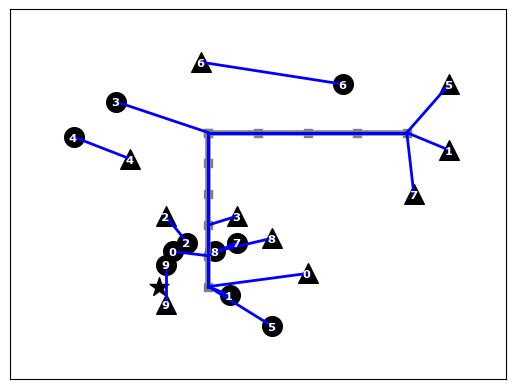

In [37]:
plot_all_nodes(stop_df, task_df, depot_df, nodes_coords_dict)
for arc in parcel_arcs:
    plt.plot([nodes_coords_dict[arc[0]][0], nodes_coords_dict[arc[1]][0]],
             [nodes_coords_dict[arc[0]][1], nodes_coords_dict[arc[1]][1]],
             c='b', linewidth=2
             )
    
plt.xticks([])
plt.yticks([])

# plt.savefig('FIGURES/illustration_parcel_arcs.pdf')